In [2]:
import re
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

Init Plugin
Init Graph Optimizer
Init Kernel


In [5]:
SIZE = 100
BATCH_SIZE = 32
EPOCHS = 100
SEED = 0

In [6]:

os.environ['PYTHONHASHSEED']=str(SEED)

random.seed(SEED)

np.random.seed(SEED)

tf.random.set_seed(SEED)

In [8]:
# df2.drop(df2.columns[df2.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
# df2.drop('label',axis = 1, inplace = True)
# df2=df2.rename(columns={'result': 'type'})

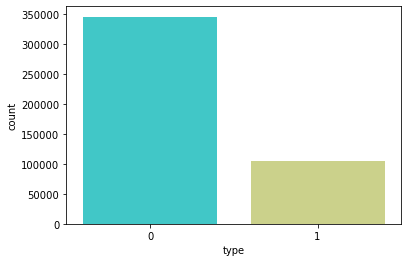

In [9]:
# sns.countplot(x='type',data=df2, palette='rainbow')
# plt.show()

In [7]:
df3=df3.rename(columns={'label': 'type'})
df3['type']=df3['type'].replace({'bad':1,'good':0})

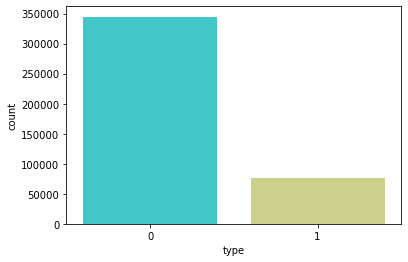

In [8]:
sns.countplot(x='type',data=df3, palette='rainbow')
plt.show()

In [9]:
def convert_to_ascii(script):
    list = []
    for char in script:
        list.append(ord(char))
    vector = np.zeros((10000))
    for char in range(len(list)):
        vector[char] = list[char]
    vector.shape = (100,100)
    return vector

In [10]:
df3.head()

,url,type
0,diaryofagameaddict.com,1
1,espdesign.com.au,1
2,iamagameaddict.com,1
3,kalantzis.net,1
4,slightlyoffcenter.net,1


In [11]:
x = df3["url"].values
y = df3["type"]

arr=np.zeros((len(x),100,100))

for i in range(len(x)):
    image=convert_to_ascii(x[i]) 
    arr[i]=image

x = arr.reshape(arr.shape[0], 100, 100, 1)


In [12]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle='True',stratify=y)

In [1]:
model = Sequential()
model.add(Conv2D(64,(3,3), activation='relu', input_shape=(100,100,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

NameError: name 'Sequential' is not defined

In [ ]:
es = EarlyStopping(monitor='val_loss', 
        mode='min', 
        patience=5,
        restore_best_weights=True, 
        verbose=1)
mc = ModelCheckpoint('best_model.h5',verbose=1,save_best_only=True, save_weights_only = True)
reduce_lr=ReduceLROnPlateau( monitor="val_loss",factor=0.7,patience=5, verbose=1)
callbacks=[es,mc,reduce_lr]

In [ ]:
model.compile(loss='binary_crossentropy',
                optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

In [ ]:
history=model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_test, y_test),callbacks=[es,mc,reduce_lr])

NameError: name 'x_train' is not defined